# 🧮 MCP Token Savings Analysis: Total Cost Comparison

This notebook compares **total costs** between two approaches:

## Cost Comparison

### WITHOUT MCP (Pure Claude Code):
- Claude reads all source files for context
- Claude generates all code/research in conversation  
- Claude writes files or you copy/paste
- **Cost = Claude tokens × Claude pricing**

### WITH MCP (Claude + Ninja/Researcher/Secretary):
- Claude sends brief spec to MCP (~250 tokens)
- MCP tool does the work (Qwen/Perplexity/file ops)
- Claude receives brief summary (~200 tokens)
- **Cost = (Claude overhead × Claude pricing) + MCP tool cost**

## Real Savings

**Savings = WITHOUT MCP cost - WITH MCP total cost**

This shows both:
1. How many Claude tokens were saved
2. What the total cost difference is (including MCP tool costs)

---

## 1. Import Dependencies & Configure Paths

Set up the environment, import required libraries, and define paths for log data and output. Also, set Claude Code pricing constants for cost calculations.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import os
from datetime import datetime

# --- MCP Data Directory Discovery ---
# You can set this to your metrics/logs directory as needed
MCP_ROOT = Path.home() / ".cache/ninja-mcp"
MCP_SUBDIR = "ac461e7834306cf0-cortex"  # Change if your hash/dir is different
METRICS_DIR = MCP_ROOT / MCP_SUBDIR / "metrics"
LOGS_DIR = MCP_ROOT / MCP_SUBDIR / "logs"
OUTPUT_DIR = MCP_ROOT / "analysis"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Default to metrics directory for analysis
LOG_DIR = METRICS_DIR

# Claude Code pricing (example, update as needed)
CLAUDE_INPUT_COST_PER_M = 8.0  # $8 per 1M input tokens
CLAUDE_OUTPUT_COST_PER_M = 24.0  # $24 per 1M output tokens
PRICE_PER_TOKEN_INPUT = CLAUDE_INPUT_COST_PER_M / 1_000_000
PRICE_PER_TOKEN_OUTPUT = CLAUDE_OUTPUT_COST_PER_M / 1_000_000

# File patterns for logs (adjust if needed)
LOG_FILE_PATTERNS = ["*.jsonl", "*.csv"]

print(f"Metrics directory: {METRICS_DIR}")
print(f"Logs directory: {LOGS_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

# Preview available files in metrics/logs
print("\nAvailable files in metrics directory:")
for f in sorted(METRICS_DIR.glob("*")):
    print("  ", f.name)
print("\nAvailable files in logs directory:")
for f in sorted(LOGS_DIR.glob("*")):
    print("  ", f.name)

# You can change LOG_DIR to LOGS_DIR or another subdir as needed for your analysis

Metrics directory: /home/angkira/.cache/ninja-mcp/ac461e7834306cf0-cortex/metrics
Logs directory: /home/angkira/.cache/ninja-mcp/ac461e7834306cf0-cortex/logs
Output directory: /home/angkira/.cache/ninja-mcp/analysis

Available files in metrics directory:
   tasks.csv

Available files in logs directory:
   20251227_224022_quick_task.json
   20251227_224022_quick_task.log
   20251227_230206_quick_task.json
   20251227_230206_quick_task.log
   20251227_230254_building_manipulation_config.json
   20251227_230254_building_manipulation_config.log
   20251227_230254_collision_manipulation_config.json
   20251227_230254_collision_manipulation_config.log
   20251227_230254_connector_config.json
   20251227_230254_connector_config.log
   20251227_230254_deformable_config.json
   20251227_230254_deformable_config.log
   20251227_230254_simple_manipulation_config.json
   20251227_230254_simple_manipulation_config.log
   20251227_230337_quick_task.json
   20251227_230337_quick_task.log
   20251227_

## 2. Load & Parse MCP Task Logs

Load logs and extract module names (coder, researcher, secretary) from tool names.

In [38]:
def load_logs(log_dir, patterns=None, verbose=True):
    """
    Load all CSV/JSONL files from the given directory. If patterns is None, loads all files.
    """
    files = []
    if patterns is None:
        files = list(log_dir.glob("*"))
    else:
        for pat in patterns:
            files.extend(log_dir.glob(pat))
    if not files:
        print(f"No log files found in {log_dir}")
        return pd.DataFrame()
    dfs = []
    for f in files:
        if f.suffix == ".jsonl":
            with open(f) as fh:
                lines = [json.loads(line) for line in fh if line.strip()]
            dfs.append(pd.json_normalize(lines))
        elif f.suffix == ".csv":
            dfs.append(pd.read_csv(f))
    if not dfs:
        return pd.DataFrame()
    df = pd.concat(dfs, ignore_index=True)
    if verbose:
        print(f"Loaded {len(df)} log entries from {log_dir}")
        print("Columns:", list(df.columns))
    return df

# --- User: Set LOG_DIR to METRICS_DIR or LOGS_DIR as needed ---
# LOG_DIR = METRICS_DIR  # (default)
# LOG_DIR = LOGS_DIR     # (uncomment to use logs)

# Load logs/metrics
df_logs = load_logs(LOG_DIR, LOG_FILE_PATTERNS)
df_logs.head()

Loaded 109 log entries from /home/angkira/.cache/ninja-mcp/ac461e7834306cf0-cortex/metrics
Columns: ['task_id', 'timestamp', 'model', 'tool_name', 'task_description', 'input_tokens', 'output_tokens', 'total_tokens', 'cache_read_tokens', 'cache_write_tokens', 'input_cost', 'output_cost', 'cache_read_cost', 'cache_write_cost', 'total_cost', 'duration_sec', 'success', 'execution_mode', 'repo_root', 'file_scope', 'error_message']


,task_id,timestamp,model,tool_name,task_description,input_tokens,output_tokens,total_tokens,cache_read_tokens,cache_write_tokens,...,output_cost,cache_read_cost,cache_write_cost,total_cost,duration_sec,success,execution_mode,repo_root,file_scope,error_message
0,df57c4c5-4c34-4d0b-8304-2857f83650a8,2025-12-27T23:40:33.075056,qwen/qwen3-coder,coder_quick_task,Create a new file at /home/angkira/Project/sof...,0,4929,4929,0,0,...,0.004683,0.0,0.0,0.004683,10.31,True,quick,/home/angkira/Project/software/cortex,NaN,NaN
1,e2f7e46d-4260-4128-a76c-e5966a047717,2025-12-28T00:01:54.356161,qwen/qwen3-coder,coder_quick_task,Completely rewrite training/config/expert_cata...,0,1,1,0,0,...,0.000001,0.0,0.0,0.000001,0.00,False,quick,/home/angkira/Project/software/cortex,NaN,Input validation failed: Path training/config/...
2,f4ba3e2f-1faa-4f75-b6c4-d3aed4291c19,2025-12-28T00:02:15.051968,qwen/qwen3-coder,coder_quick_task,Completely rewrite the file at training/config...,0,7421,7421,0,0,...,0.007050,0.0,0.0,0.007050,8.13,True,quick,/home/angkira/Project/software/cortex,NaN,NaN
3,4a272e4f-cc60-440e-bf30-9751c2308a32,2025-12-28T00:03:06.247250,qwen/qwen3-coder,coder_plan_step_parallel,Create simple_manipulation_expert.yaml: Create...,0,2453,2453,0,0,...,0.002330,0.0,0.0,0.002330,7.64,True,quick,/home/angkira/Project/software/cortex,NaN,NaN
4,a3da9b0a-505d-41ec-8870-81356faff0e8,2025-12-28T00:03:06.247579,qwen/qwen3-coder,coder_plan_step_parallel,Create collision_manipulation_expert.yaml: Cre...,0,1848,1848,0,0,...,0.001756,0.0,0.0,0.001756,11.42,True,quick,/home/angkira/Project/software/cortex,NaN,NaN


In [39]:
# Extract module name from tool_name (coder, researcher, secretary)
if not df_logs.empty and "tool_name" in df_logs:
    df_logs["module"] = df_logs["tool_name"].str.extract(r'^([^_]+)')[0]
    
    print("\nModule distribution:")
    print(df_logs["module"].value_counts())
    print(f"\nUnique modules found: {df_logs['module'].unique().tolist()}")


Module distribution:
module
coder    109
Name: count, dtype: int64

Unique modules found: ['coder']


## 3. Estimate Baseline: Claude Code Without MCP

If Claude Code did these tasks directly (no MCP), how many tokens would it consume?

**Estimation methodology:**
1. **Context Reading**: Claude needs to read relevant source files
   - Small tasks: ~5k tokens (1-2 files)
   - Medium tasks: ~20k tokens (5-10 files)
   - Large tasks: ~50k+ tokens (many files)
   
2. **Code Generation**: Claude generates code in conversation
   - Use Ninja's output_tokens as proxy for code size
   - But Claude is less efficient (more explanation, iteration)
   - Multiply by ~2x for conversational overhead
   
3. **Total Baseline** = Context Reading + (Code Generation × 2)

We'll estimate context size based on Ninja's output size as a heuristic.

In [40]:
if not df_logs.empty:
    # Parse timestamps
    if "timestamp" in df_logs:
        df_logs["timestamp"] = pd.to_datetime(df_logs["timestamp"], errors="coerce")
    
    # Estimate context size Claude would need to read (without MCP)
    # Heuristic: Larger output = more complex task = more context needed
    def estimate_context_tokens(output_tokens):
        if output_tokens < 1000:
            return 5000  # Small task: 1-2 files
        elif output_tokens < 3000:
            return 15000  # Medium task: 3-5 files
        elif output_tokens < 7000:
            return 30000  # Large task: 10+ files
        else:
            return 50000  # Very large task: many files
    
    df_logs["estimated_context_tokens"] = df_logs["output_tokens"].apply(estimate_context_tokens)
    
    # Claude's code generation (conversational, with explanation)
    # 2x the actual code size due to explanation overhead
    df_logs["estimated_claude_output"] = df_logs["output_tokens"] * 2
    
    # Total baseline: context reading + code generation
    df_logs["baseline_tokens"] = df_logs["estimated_context_tokens"] + df_logs["estimated_claude_output"]
    
    print("Baseline estimation complete.")
    print(f"\nExample breakdown for first task:")
    print(f"  Ninja output: {df_logs.iloc[0]['output_tokens']} tokens")
    print(f"  Estimated context reading: {df_logs.iloc[0]['estimated_context_tokens']} tokens")
    print(f"  Estimated Claude output (2x): {df_logs.iloc[0]['estimated_claude_output']} tokens")
    print(f"  Total baseline: {df_logs.iloc[0]['baseline_tokens']} tokens")
    
    df_logs[["task_description", "output_tokens", "estimated_context_tokens", "baseline_tokens"]].head()

Baseline estimation complete.

Example breakdown for first task:
  Ninja output: 4929 tokens
  Estimated context reading: 30000 tokens
  Estimated Claude output (2x): 9858 tokens
  Total baseline: 39858 tokens


## 4. Calculate Total Cost WITH MCP

When using MCP, the total cost includes:
1. **Claude overhead**: Spec + summary (~450 tokens × Claude price)
2. **MCP tool cost**: Actual cost from Ninja/Researcher/Secretary (logged in `total_cost`)

**Total WITH MCP = Claude overhead cost + MCP tool cost**

In [41]:
if not df_logs.empty:
    # Conservative estimates for MCP tool call overhead
    SPEC_TOKENS = 250  # Task description sent to MCP
    SUMMARY_TOKENS = 200  # Summary returned from MCP
    
    # Claude tokens used with MCP = spec + summary
    df_logs["mcp_claude_tokens"] = SPEC_TOKENS + SUMMARY_TOKENS
    
    # Claude cost for MCP overhead
    df_logs["mcp_claude_cost"] = df_logs["mcp_claude_tokens"] * PRICE_PER_TOKEN_INPUT
    
    # Total cost WITH MCP = Claude overhead + MCP tool cost (from logs)
    df_logs["total_cost_with_mcp"] = df_logs["mcp_claude_cost"] + df_logs["total_cost"]
    
    # Calculate baseline cost (Claude doing everything)
    df_logs["baseline_cost"] = df_logs["baseline_tokens"] * PRICE_PER_TOKEN_INPUT
    
    print("Cost calculation complete.")
    print(f"\nPer-task breakdown (example from first task):")
    print(f"  WITHOUT MCP:")
    print(f"    Claude tokens: {df_logs.iloc[0]['baseline_tokens']:,}")
    print(f"    Cost: ${df_logs.iloc[0]['baseline_cost']:.4f}")
    print(f"\n  WITH MCP:")
    print(f"    Claude overhead: {SPEC_TOKENS + SUMMARY_TOKENS} tokens → ${df_logs.iloc[0]['mcp_claude_cost']:.4f}")
    print(f"    MCP tool cost: ${df_logs.iloc[0]['total_cost']:.4f}")
    print(f"    Total: ${df_logs.iloc[0]['total_cost_with_mcp']:.4f}")
    
    df_logs[["task_description", "baseline_cost", "mcp_claude_cost", "total_cost", "total_cost_with_mcp"]].head()

Cost calculation complete.

Per-task breakdown (example from first task):
  WITHOUT MCP:
    Claude tokens: 39,858
    Cost: $0.3189

  WITH MCP:
    Claude overhead: 450 tokens → $0.0036
    MCP tool cost: $0.0047
    Total: $0.0083


## 5. Calculate Total Savings

**Savings = Baseline cost (Claude only) - Total cost WITH MCP (Claude + tools)**

This shows the real cost benefit of using MCP delegation.

In [42]:
if not df_logs.empty:
    # Calculate savings
    df_logs["tokens_saved"] = df_logs["baseline_tokens"] - df_logs["mcp_claude_tokens"]
    df_logs["cost_saved_usd"] = df_logs["baseline_cost"] - df_logs["total_cost_with_mcp"]
    df_logs["savings_pct"] = 100 * df_logs["tokens_saved"] / df_logs["baseline_tokens"]
    df_logs["cost_savings_pct"] = 100 * df_logs["cost_saved_usd"] / df_logs["baseline_cost"]
    
    # Overall statistics
    total_tasks = len(df_logs)
    baseline_total_cost = df_logs["baseline_cost"].sum()
    mcp_total_cost = df_logs["total_cost_with_mcp"].sum()
    total_cost_saved = df_logs["cost_saved_usd"].sum()
    total_tokens_saved = df_logs["tokens_saved"].sum()
    
    # Break down MCP costs
    claude_overhead_cost = df_logs["mcp_claude_cost"].sum()
    mcp_tool_cost = df_logs["total_cost"].sum()
    
    print("="*80)
    print("TOTAL COST COMPARISON: PURE CLAUDE CODE vs CLAUDE + MCP TOOLS")
    print("="*80)
    print(f"\nTotal tasks analyzed: {total_tasks}")
    
    print(f"\n{'WITHOUT MCP (Pure Claude Code)':^50}")
    print(f"  Estimated Claude tokens: {df_logs['baseline_tokens'].sum():,}")
    print(f"  Estimated cost: ${baseline_total_cost:.2f}")
    
    print(f"\n{'WITH MCP (Claude + Tools)':^50}")
    print(f"  Claude overhead: {df_logs['mcp_claude_tokens'].sum():,} tokens → ${claude_overhead_cost:.2f}")
    print(f"  MCP tool costs: ${mcp_tool_cost:.2f}")
    print(f"    (Ninja/Researcher/Secretary using cheaper models)")
    print(f"  Total cost: ${mcp_total_cost:.2f}")
    
    print(f"\n{'🎉 TOTAL SAVINGS':^50}")
    print(f"  Claude tokens saved: {total_tokens_saved:,}")
    print(f"  Cost saved: ${total_cost_saved:.2f}")
    print(f"  Cost reduction: {100 * total_cost_saved / baseline_total_cost:.1f}%")
    print(f"  Token reduction factor: {df_logs['baseline_tokens'].sum() / df_logs['mcp_claude_tokens'].sum():.1f}x")
    
    print(f"\n{'ROI Analysis':^50}")
    if total_cost_saved > 0:
        print(f"  For every $1 spent on MCP tools, you save ${total_cost_saved / mcp_tool_cost:.2f}")
    else:
        print(f"  MCP costs more than baseline (edge case or conservative estimates)")
    
    print("="*80)
    
    # Per-task summary statistics
    print("\nPer-task savings distribution:")
    summary = df_logs[["tokens_saved", "cost_saved_usd", "savings_pct", "cost_savings_pct"]].describe(percentiles=[.25, .5, .75, .9, .99])
    display(summary)
    
    # Show top 10 tasks by cost savings
    print("\nTop 10 tasks by cost saved:")
    top_tasks = df_logs.nlargest(10, "cost_saved_usd")[["task_description", "baseline_cost", "total_cost_with_mcp", "cost_saved_usd", "cost_savings_pct"]]
    display(top_tasks)

TOTAL COST COMPARISON: PURE CLAUDE CODE vs CLAUDE + MCP TOOLS

Total tasks analyzed: 109

          WITHOUT MCP (Pure Claude Code)          
  Estimated Claude tokens: 5,651,504
  Estimated cost: $45.21

            WITH MCP (Claude + Tools)             
  Claude overhead: 49,050 tokens → $0.39
  MCP tool costs: $0.96
    (Ninja/Researcher/Secretary using cheaper models)
  Total cost: $1.36

                 🎉 TOTAL SAVINGS                  
  Claude tokens saved: 5,602,454
  Cost saved: $43.85
  Cost reduction: 97.0%
  Token reduction factor: 115.2x

                   ROI Analysis                   
  For every $1 spent on MCP tools, you save $45.45

Per-task savings distribution:


,tokens_saved,cost_saved_usd,savings_pct,cost_savings_pct
count,109.000000,109.000000,109.000000,109.000000
mean,51398.660550,0.402336,97.580627,95.976272
std,34279.089976,0.266412,3.049163,2.363327
min,4552.000000,0.036415,91.003599,91.001100
25%,18886.000000,0.149028,97.672735,96.249132
50%,64288.000000,0.507303,99.304890,96.994994
75%,79080.000000,0.618613,99.434176,97.355065
90%,90914.400000,0.707667,99.507397,97.692524
99%,120944.160000,0.933641,99.629300,97.952603
max,128436.000000,0.990017,99.650854,97.975377



Top 10 tasks by cost saved:


,task_description,baseline_cost,total_cost_with_mcp,cost_saved_usd,cost_savings_pct
35,Rewrite all 5 expert models to be standalone n...,1.031088,0.041071,0.990017,96.016732
32,Create training/test_expert_pipeline.py - Comp...,0.972336,0.037582,0.934754,96.134875
87,Add Expert Set methods to ExpertRegistry: Add ...,0.957552,0.036705,0.920847,96.166788
13,Implement diffusion transformer components: Cr...,0.836752,0.029532,0.807220,96.470639
99,Implement timestamp-synced frame extractor: CR...,0.829552,0.029105,0.800447,96.491480
102,Implement multi-step VLM decomposer: CREATE FI...,0.806192,0.027718,0.778474,96.561861
93,Integrate Expert Set registry with ReflexRunti...,0.781872,0.026274,0.755598,96.639603
33,Create training/test_models_standalone.py - Li...,0.776336,0.025945,0.750391,96.658019
28,Implement Diffusion Trainer: Create training/t...,0.752400,0.024524,0.727876,96.740564
92,Extend GpuAwareModelLoader to support optional...,0.751072,0.024445,0.726627,96.745319


## 6. Per-Module Analysis

Break down savings by MCP module: Coder, Researcher, and Secretary.

In [43]:
if not df_logs.empty:
    # Per-module analysis
    if "module" in df_logs:
        print("="*80)
        print("SAVINGS BY MCP MODULE (Coder, Researcher, Secretary)")
        print("="*80)
        
        module_agg = df_logs.groupby("module").agg(
            task_count=("task_id", "count"),
            baseline_cost=("baseline_cost", "sum"),
            claude_overhead_cost=("mcp_claude_cost", "sum"),
            mcp_tool_cost=("total_cost", "sum"),
            total_cost_with_mcp=("total_cost_with_mcp", "sum"),
            cost_saved=("cost_saved_usd", "sum"),
            tokens_saved=("tokens_saved", "sum"),
            avg_cost_savings_pct=("cost_savings_pct", "mean"),
            success_rate=("success", "mean")
        ).sort_values("cost_saved", ascending=False)
        
        module_agg["roi"] = module_agg["cost_saved"] / module_agg["mcp_tool_cost"]
        
        print("\nCost breakdown by module:")
        display(module_agg)
        
        # Print summary for each module
        for module in module_agg.index:
            print(f"\n{module.upper()} Module:")
            print(f"  Tasks: {module_agg.loc[module, 'task_count']}")
            print(f"  Baseline cost: ${module_agg.loc[module, 'baseline_cost']:.2f}")
            print(f"  WITH MCP total: ${module_agg.loc[module, 'total_cost_with_mcp']:.2f}")
            print(f"    - Claude overhead: ${module_agg.loc[module, 'claude_overhead_cost']:.2f}")
            print(f"    - Tool cost: ${module_agg.loc[module, 'mcp_tool_cost']:.2f}")
            print(f"  Cost saved: ${module_agg.loc[module, 'cost_saved']:.2f}")
            print(f"  ROI: ${module_agg.loc[module, 'roi']:.2f} saved per $1 spent")
            print(f"  Success rate: {module_agg.loc[module, 'success_rate']*100:.1f}%")
    
    # Per-tool breakdown
    print("\n" + "="*80)
    print("SAVINGS BY SPECIFIC TOOL")
    print("="*80)
    
    if "tool_name" in df_logs:
        tool_agg = df_logs.groupby("tool_name").agg(
            task_count=("task_id", "count"),
            total_baseline=("baseline_tokens", "sum"),
            total_mcp_usage=("mcp_claude_tokens", "sum"),
            cost_saved=("cost_saved_usd", "sum"),
            avg_savings_pct=("cost_savings_pct", "mean")
        ).sort_values("cost_saved", ascending=False)
        
        tool_agg["reduction_factor"] = tool_agg["total_baseline"] / tool_agg["total_mcp_usage"]
        display(tool_agg.head(10))
    
    # Breakdown by task size
    print("\n" + "="*80)
    print("SAVINGS BY TASK COMPLEXITY")
    print("="*80)
    
    def categorize_task_size(output_tokens):
        if output_tokens < 1000:
            return "Small (<1k tokens)"
        elif output_tokens < 3000:
            return "Medium (1-3k)"
        elif output_tokens < 7000:
            return "Large (3-7k)"
        else:
            return "Very Large (7k+)"
    
    df_logs["task_size"] = df_logs["output_tokens"].apply(categorize_task_size)
    
    size_agg = df_logs.groupby("task_size").agg(
        task_count=("task_id", "count"),
        avg_output=("output_tokens", "mean"),
        avg_baseline_cost=("baseline_cost", "mean"),
        avg_mcp_cost=("total_cost_with_mcp", "mean"),
        avg_saved=("cost_saved_usd", "mean"),
        total_saved=("cost_saved_usd", "sum"),
        avg_savings_pct=("cost_savings_pct", "mean")
    )
    
    # Order by task size
    size_order = ["Small (<1k tokens)", "Medium (1-3k)", "Large (3-7k)", "Very Large (7k+)"]
    size_agg = size_agg.reindex([s for s in size_order if s in size_agg.index])
    display(size_agg)

SAVINGS BY MCP MODULE (Coder, Researcher, Secretary)

Cost breakdown by module:


,task_count,baseline_cost,claude_overhead_cost,mcp_tool_cost,total_cost_with_mcp,cost_saved,tokens_saved,avg_cost_savings_pct,success_rate,roi
module,,,,,,,,,,
coder,109,45.212032,0.3924,0.96496,1.35736,43.854672,5602454,95.976272,0.981651,45.44714



CODER Module:
  Tasks: 109
  Baseline cost: $45.21
  WITH MCP total: $1.36
    - Claude overhead: $0.39
    - Tool cost: $0.96
  Cost saved: $43.85
  ROI: $45.45 saved per $1 spent
  Success rate: 98.2%

SAVINGS BY SPECIFIC TOOL


,task_count,total_baseline,total_mcp_usage,cost_saved,avg_savings_pct,reduction_factor
tool_name,,,,,,
coder_plan_step_sequential,41,2797290,18450,21.740380,97.184755,151.614634
coder_quick_task,32,1919238,14400,14.894691,96.099290,133.280417
coder_plan_step_parallel,22,864648,9900,6.707527,96.702139,87.338182
coder_execute_plan_sequential,9,45198,4050,0.329094,91.014536,11.160000
coder_execute_plan_parallel,5,25130,2250,0.182980,91.016713,11.168889



SAVINGS BY TASK COMPLEXITY


,task_count,avg_output,avg_baseline_cost,avg_mcp_cost,avg_saved,total_saved,avg_savings_pct
task_size,,,,,,,
Small (<1k tokens),20,119.650000,0.041914,0.003713,0.038201,0.764021,91.120971
Medium (1-3k),18,2031.166667,0.152499,0.005530,0.146969,2.645444,96.384791
Large (3-7k),15,5535.600000,0.328570,0.008859,0.319711,4.795661,97.314782
Very Large (7k+),56,15960.071429,0.655361,0.018762,0.636599,35.649546,97.220469


## 7. Visualizations

Visual analysis of token savings patterns.

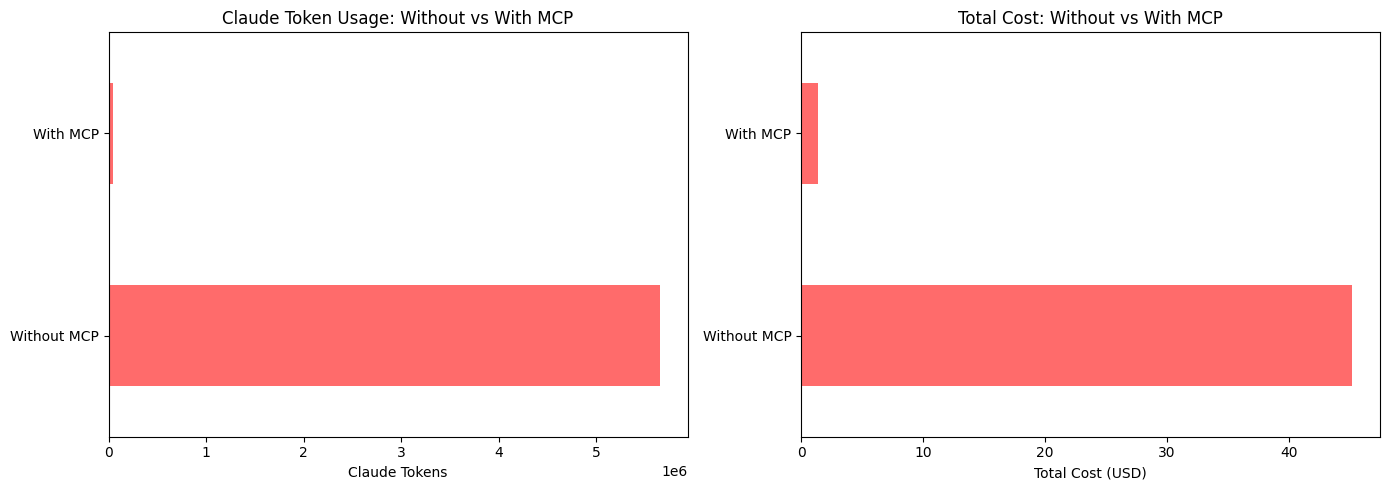

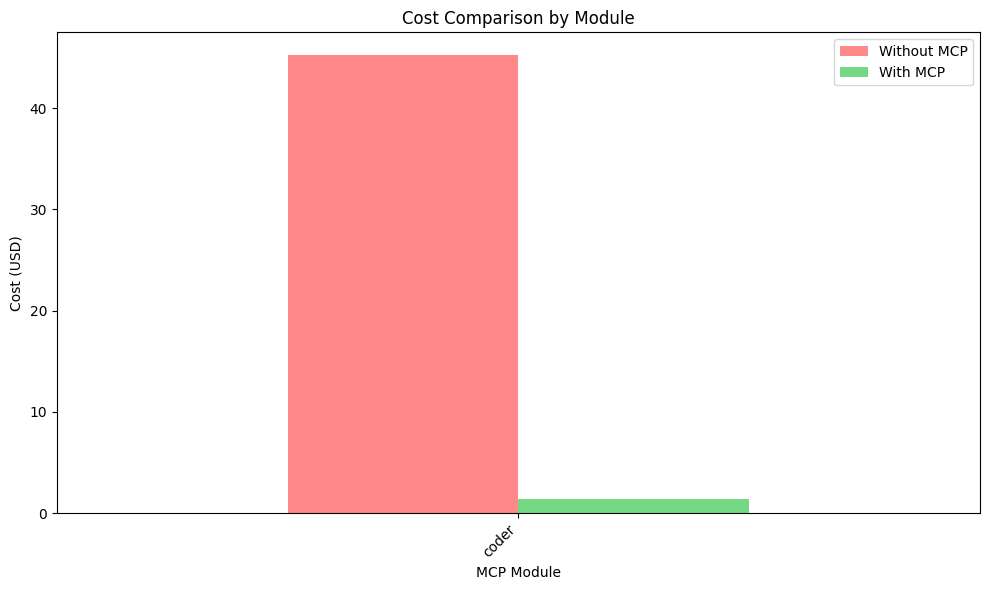

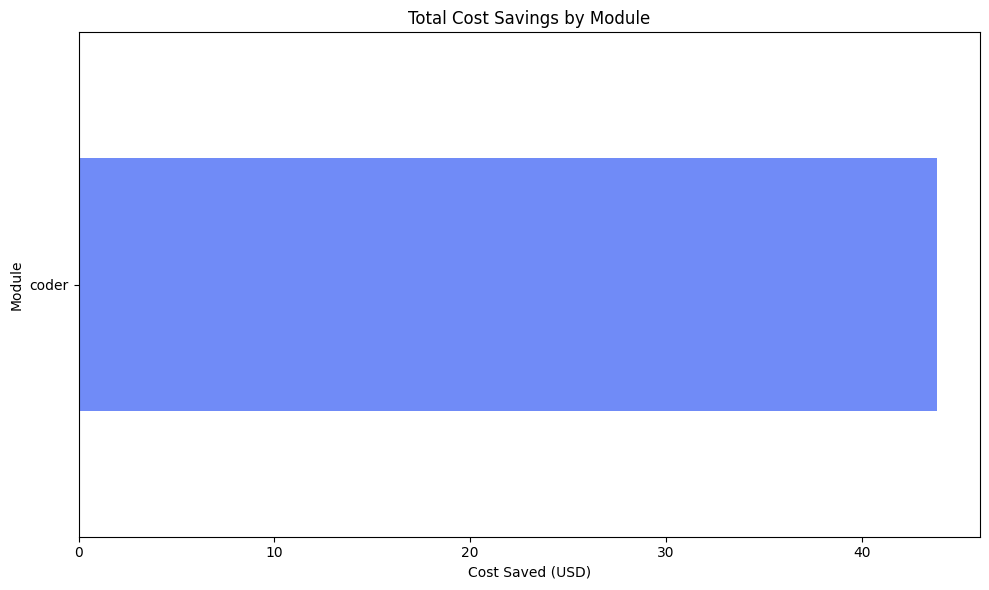

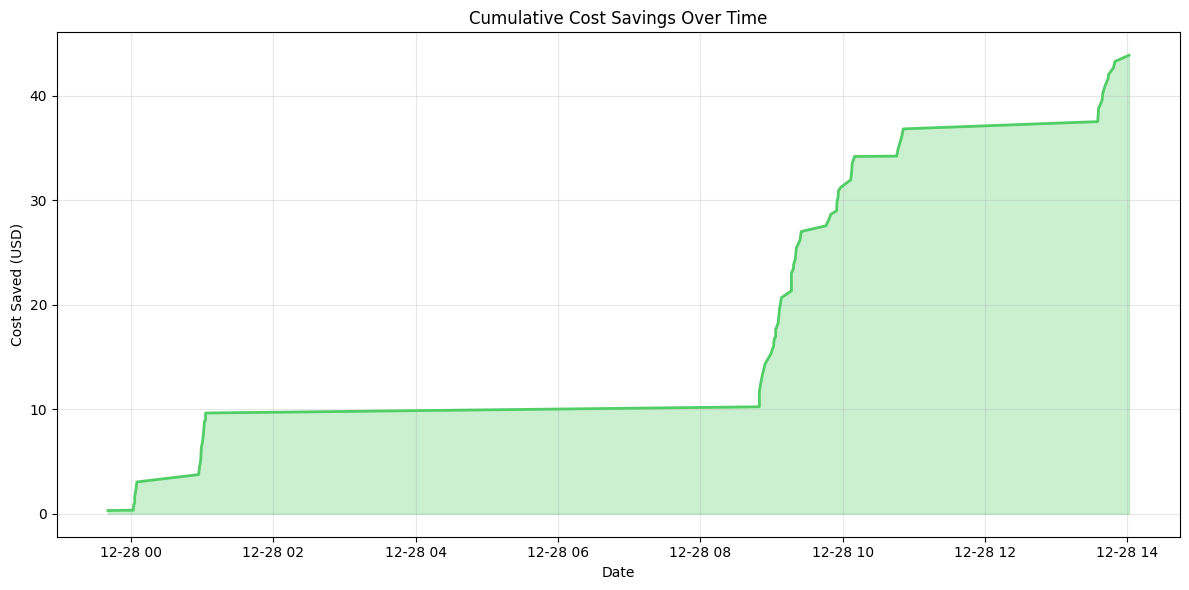

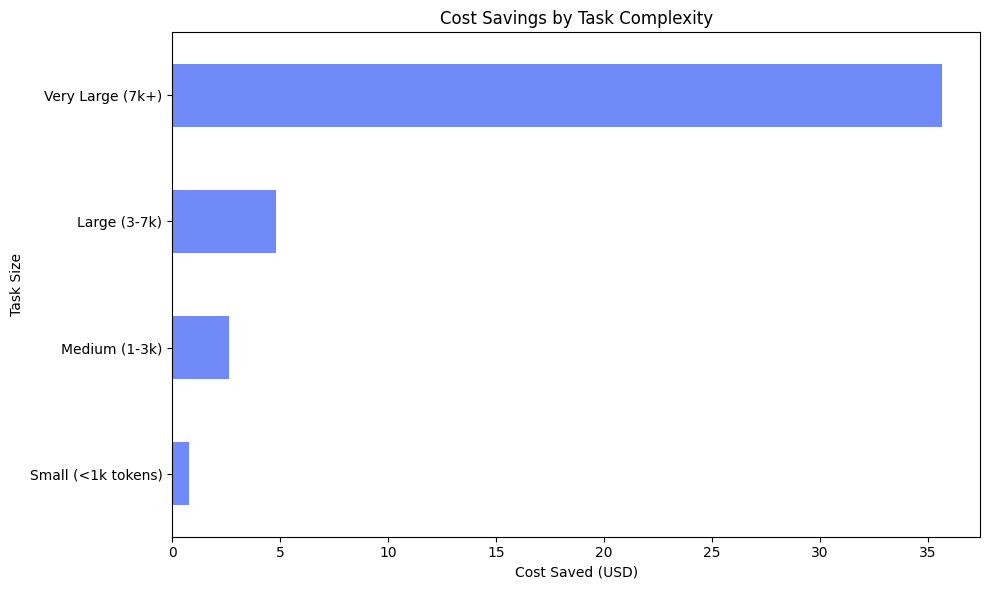


✅ Exported analysis to /home/angkira/.cache/ninja-mcp/analysis
   - mcp_cost_analysis.csv/json
   - summary_stats.json (with per-module breakdown)
   - Visualization PNGs


In [44]:
if not df_logs.empty:
    # 1. Overall cost comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Token comparison
    comparison_tokens = pd.DataFrame({
        'Without MCP': [df_logs['baseline_tokens'].sum()],
        'With MCP': [df_logs['mcp_claude_tokens'].sum()]
    })
    comparison_tokens.T.plot(kind='barh', ax=ax1, color=['#ff6b6b', '#51cf66'], legend=False)
    ax1.set_xlabel('Claude Tokens')
    ax1.set_title('Claude Token Usage: Without vs With MCP')
    ax1.set_ylabel('')
    
    # Total cost comparison (including MCP tool costs)
    cost_data = pd.DataFrame({
        'Without MCP': [df_logs['baseline_cost'].sum()],
        'With MCP': [df_logs['total_cost_with_mcp'].sum()]
    })
    cost_data.T.plot(kind='barh', ax=ax2, color=['#ff6b6b', '#51cf66'], legend=False)
    ax2.set_xlabel('Total Cost (USD)')
    ax2.set_title('Total Cost: Without vs With MCP')
    ax2.set_ylabel('')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "cost_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    # 2. Per-module cost breakdown
    if "module" in df_logs:
        module_costs = df_logs.groupby("module").agg({
            "baseline_cost": "sum",
            "total_cost_with_mcp": "sum"
        })
        
        fig, ax = plt.subplots(figsize=(10, 6))
        module_costs.plot(kind='bar', ax=ax, color=['#ff6b6b', '#51cf66'], alpha=0.8)
        ax.set_xlabel('MCP Module')
        ax.set_ylabel('Cost (USD)')
        ax.set_title('Cost Comparison by Module')
        ax.legend(['Without MCP', 'With MCP'])
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / "module_cost_comparison.png", dpi=150, bbox_inches='tight')
        plt.show()
        
        # Savings by module
        fig, ax = plt.subplots(figsize=(10, 6))
        module_savings = df_logs.groupby("module")["cost_saved_usd"].sum().sort_values()
        module_savings.plot(kind='barh', ax=ax, color='#4c6ef5', alpha=0.8)
        ax.set_xlabel('Cost Saved (USD)')
        ax.set_title('Total Cost Savings by Module')
        ax.set_ylabel('Module')
        
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / "module_savings.png", dpi=150, bbox_inches='tight')
        plt.show()
    
    # 3. Cumulative savings over time
    if "timestamp" in df_logs and not df_logs["timestamp"].isnull().all():
        df_sorted = df_logs.sort_values("timestamp")
        df_sorted["cumulative_cost_saved"] = df_sorted["cost_saved_usd"].cumsum()
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(df_sorted["timestamp"], df_sorted["cumulative_cost_saved"], color="#51cf66", linewidth=2)
        ax.fill_between(df_sorted["timestamp"], df_sorted["cumulative_cost_saved"], alpha=0.3, color="#51cf66")
        ax.set_ylabel("Cost Saved (USD)")
        ax.set_xlabel("Date")
        ax.set_title("Cumulative Cost Savings Over Time")
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / "cumulative_savings.png", dpi=150, bbox_inches='tight')
        plt.show()
    
    # 4. Savings distribution by task size
    if "task_size" in df_logs:
        fig, ax = plt.subplots(figsize=(10, 6))
        size_savings = df_logs.groupby("task_size")["cost_saved_usd"].sum()
        size_order = ["Small (<1k tokens)", "Medium (1-3k)", "Large (3-7k)", "Very Large (7k+)"]
        size_savings = size_savings.reindex([s for s in size_order if s in size_savings.index])
        
        size_savings.plot(kind='barh', ax=ax, color='#4c6ef5', alpha=0.8)
        ax.set_xlabel('Cost Saved (USD)')
        ax.set_title('Cost Savings by Task Complexity')
        ax.set_ylabel('Task Size')
        
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / "savings_by_complexity.png", dpi=150, bbox_inches='tight')
        plt.show()
    
    # Export processed data
    df_logs.to_csv(OUTPUT_DIR / "mcp_cost_analysis.csv", index=False)
    df_logs.to_json(OUTPUT_DIR / "mcp_cost_analysis.json", orient="records", indent=2)
    
    # Export summary statistics
    summary_stats = {
        "analysis_type": "total_cost_comparison",
        "total_tasks": len(df_logs),
        "baseline_cost_usd": float(df_logs["baseline_cost"].sum()),
        "mcp_total_cost_usd": float(df_logs["total_cost_with_mcp"].sum()),
        "claude_overhead_cost_usd": float(df_logs["mcp_claude_cost"].sum()),
        "mcp_tool_cost_usd": float(df_logs["total_cost"].sum()),
        "total_cost_saved_usd": float(df_logs["cost_saved_usd"].sum()),
        "cost_savings_pct": float(100 * df_logs["cost_saved_usd"].sum() / df_logs["baseline_cost"].sum()),
        "claude_tokens_saved": int(df_logs["tokens_saved"].sum()),
        "token_reduction_factor": float(df_logs["baseline_tokens"].sum() / df_logs["mcp_claude_tokens"].sum()),
        "success_rate": float(df_logs["success"].sum() / len(df_logs)),
        "roi": float(df_logs["cost_saved_usd"].sum() / df_logs["total_cost"].sum())
    }
    
    # Per-module summary
    if "module" in df_logs:
        summary_stats["per_module"] = {}
        for module in df_logs["module"].unique():
            module_df = df_logs[df_logs["module"] == module]
            summary_stats["per_module"][module] = {
                "task_count": len(module_df),
                "baseline_cost": float(module_df["baseline_cost"].sum()),
                "total_cost_with_mcp": float(module_df["total_cost_with_mcp"].sum()),
                "cost_saved": float(module_df["cost_saved_usd"].sum()),
                "roi": float(module_df["cost_saved_usd"].sum() / module_df["total_cost"].sum()),
                "success_rate": float(module_df["success"].sum() / len(module_df))
            }
    
    with open(OUTPUT_DIR / "summary_stats.json", "w") as f:
        json.dump(summary_stats, f, indent=2)
    
    print(f"\n✅ Exported analysis to {OUTPUT_DIR}")
    print(f"   - mcp_cost_analysis.csv/json")
    print(f"   - summary_stats.json (with per-module breakdown)")
    print(f"   - Visualization PNGs")